## Statistics

In [1]:
# imports
import pandas as pd; pd.set_option('display.max_columns', None)
import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from tqdm.notebook import tqdm

In [2]:
### melt session level dataframes
psim_crl_v1_data = pd.read_csv('analyses/dataframes/psim_crl_v1_data.csv')
psim_crl_v1_data

,subject,exp_type,experiment,session,localization,montage,lag,psim_crl,non_crl
0,R1001P,intracranial,FR1,0,0,0,-11,NaN,NaN
1,R1001P,intracranial,FR1,0,0,0,-10,NaN,NaN
2,R1001P,intracranial,FR1,0,0,0,-9,NaN,NaN
3,R1001P,intracranial,FR1,0,0,0,-8,NaN,NaN
4,R1001P,intracranial,FR1,0,0,0,-7,NaN,NaN
...,...,...,...,...,...,...,...,...,...
135193,LTP393,scalp,ltpFR2,9,0,9,19,NaN,NaN
135194,LTP393,scalp,ltpFR2,9,0,9,20,NaN,NaN
135195,LTP393,scalp,ltpFR2,9,0,9,21,NaN,NaN
135196,LTP393,scalp,ltpFR2,9,0,9,22,NaN,NaN


In [3]:
# select lags -7 to 7
df = psim_crl_v1_data.query("lag >= -7 and lag <= 7")

# take absolute value of lag
df['abs_lag'] = abs(df.lag)

/tmp/ipykernel_9592/647509663.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['abs_lag'] = abs(df.lag)


In [6]:
dfm = pd.melt(df, id_vars=['subject', 'exp_type', 'experiment', 'session', 'localization', 'montage', 'lag', 'abs_lag'],
              value_vars=['psim_crl', 'non_crl'], var_name='psim', value_name='crl')
dfm['psim'] = [1 if x=='psim_crl' else 0 if x=='non_crl' else np.nan for x in dfm.psim]         # code psim = 1, non = 0

In [8]:
dfm.to_csv('psim_crl_v1_dfm.csv', index=False)

#### Phonetic Clustering Score

1-sample t-test against chance (v1 = 0, v2 = 0.5) within experiment type.  FDR correction with Benjamini-Yekutieli (correct both versions together).

In [10]:
def pcs_statistics(pcs_v1_data_bsa, pcs_v2_data_bsa):
    stats = []

    # v1
    for et, data in pcs_v1_data_bsa.groupby('exp_type'):
        res = scipy.stats.ttest_1samp(data.pcs, popmean=0, nan_policy='omit', alternative='two-sided')
        stats.append(('v1', et, res.statistic, res.pvalue, res.df))

    # v2
    for et, data in pcs_v2_data_bsa.groupby('exp_type'):
        res = scipy.stats.ttest_1samp(data.pcs, popmean=0.5, nan_policy='omit', alternative='two-sided')
        stats.append(('v2', et, res.statistic, res.pvalue, res.df))

    # save results as dataframe
    stats = pd.DataFrame(stats, columns=['version', 'exp_type', 't_stat', 'p_val', 'dof'])

    # FDR correction
    stats['p_val_fdr'] = scipy.stats.false_discovery_control(stats.p_val, method='by')
    
    return stats

In [11]:
pcs_v1_data_bsa = pd.read_csv('analyses/dataframes/pcs_v1_data_bsa.csv')
pcs_v2_data_bsa = pd.read_csv('analyses/dataframes/pcs_v2_data_bsa.csv')
pcs_stats = pcs_statistics(pcs_v1_data_bsa, pcs_v2_data_bsa)
pcs_stats

,version,exp_type,t_stat,p_val,dof,p_val_fdr
0,v1,intracranial,1.266110,2.061824e-01,416,5.727289e-01
1,v1,scalp,7.575934,6.698186e-12,126,5.581821e-11
2,v2,intracranial,-2.380739,1.772621e-02,417,7.385920e-02
3,v2,scalp,0.250263,8.027918e-01,126,1.000000e+00


#### Phonetic-CRL

In [118]:
psim_crl_v1_data_bsa = pd.read_csv('analyses/dataframes/psim_crl_v1_data_bsa.csv')
psim_crl_v1_data_bsa.lag.unique()

array([-19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,  -7,
        -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,
         7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,
       -23, -22, -21, -20,  20,  21,  22,  23])

In [119]:
psim_crl_v1_df = psim_crl_v1_data_bsa.query("lag >= -7 and lag <= 7 and lag != 0")
psim_crl_v1_df = psim_crl_v1_df.dropna()

In [120]:
psim_crl_v1_df

,subject,exp_type,experiment,lag,psim_crl,non_crl
12,BW001,intracranial,pyFR,-7,3338.500000,3473.000000
18,BW001,intracranial,pyFR,-1,2275.000000,5732.000000
22,BW001,intracranial,pyFR,3,4482.000000,2543.500000
57,BW013,intracranial,pyFR,-1,5445.000000,4049.000000
59,BW013,intracranial,pyFR,1,2296.500000,1938.666667
...,...,...,...,...,...,...
16449,LTP393,scalp,ltpFR2,3,3694.974359,3811.463716
16450,LTP393,scalp,ltpFR2,4,2106.900000,3017.990714
16451,LTP393,scalp,ltpFR2,5,2161.550000,2993.749702
16452,LTP393,scalp,ltpFR2,6,1897.433333,3548.662037


In [116]:
psim_crl_v1_df = pd.melt(psim_crl_v1_df, id_vars=['subject', 'exp_type', 'experiment', 'lag'],
                         value_vars=['psim_crl', 'non_crl'], var_name='psim_label', value_name='crl')
psim_crl_v1_df

,subject,exp_type,experiment,lag,psim_label,crl
0,BW001,intracranial,pyFR,-7,psim_crl,3338.500000
1,BW001,intracranial,pyFR,-1,psim_crl,2275.000000
2,BW001,intracranial,pyFR,3,psim_crl,4482.000000
3,BW013,intracranial,pyFR,-1,psim_crl,5445.000000
4,BW013,intracranial,pyFR,1,psim_crl,2296.500000
...,...,...,...,...,...,...
7175,LTP393,scalp,ltpFR2,3,non_crl,3811.463716
7176,LTP393,scalp,ltpFR2,4,non_crl,3017.990714
7177,LTP393,scalp,ltpFR2,5,non_crl,2993.749702
7178,LTP393,scalp,ltpFR2,6,non_crl,3548.662037


In [117]:
psim_crl_v1_df.to_csv('psim_crl_v1_df.csv', index=False)

In [99]:
stats = []

for (et, l), data in psim_crl_v1_df.groupby(['exp_type', 'lag']):
    res = scipy.stats.ttest_rel(data.psim_crl, data.non_crl, nan_policy='omit', alternative='two-sided')
    stats.append((et, l, res.statistic, res.pvalue, res.df))
    
# save results as dataframe
stats = pd.DataFrame(stats, columns=['exp_type', 'lag', 't_stat', 'p_val', 'dof'])

# FDR correction
stats['p_val_fdr'] = scipy.stats.false_discovery_control(stats.p_val, method='by')

In [100]:
stats

,exp_type,lag,t_stat,p_val,dof,p_val_fdr
0,intracranial,-7,-0.123240,0.902442,47,1.000000
1,intracranial,-6,-0.050196,0.960107,71,1.000000
2,intracranial,-5,-0.184883,0.853807,77,1.000000
3,intracranial,-4,-1.576343,0.118618,86,1.000000
4,intracranial,-3,-0.879256,0.381179,110,1.000000
5,intracranial,-2,-1.530427,0.128234,136,1.000000
6,intracranial,-1,-1.569108,0.118180,203,1.000000
7,intracranial,1,-2.245406,0.025420,322,0.465871
8,intracranial,2,-2.640140,0.008901,213,0.326236
9,intracranial,3,-0.680826,0.496930,166,1.000000


In [91]:
stats

,exp_type,lag,t_stat,p_val,dof,p_val_fdr
0,intracranial,-5,-0.184883,0.853807,77,1.000000
1,intracranial,-4,-1.576343,0.118618,86,0.838822
2,intracranial,-3,-0.879256,0.381179,110,1.000000
3,intracranial,-2,-1.530427,0.128234,136,0.838822
4,intracranial,-1,-1.569108,0.118180,203,0.838822
5,intracranial,1,-2.245406,0.025420,322,0.304851
6,intracranial,2,-2.640140,0.008901,213,0.213478
7,intracranial,3,-0.680826,0.496930,166,1.000000
8,intracranial,4,-0.577749,0.564425,131,1.000000
9,intracranial,5,-1.061880,0.290441,119,1.000000


In [128]:
psim_crl_v2_data_bsa = pd.read_csv('analyses/dataframes/psim_crl_v2_data_bsa.csv')
psim_crl_v2_data_bsa

,subject,exp_type,experiment,bin,psim,irt
0,BW001,intracranial,pyFR,0.0,0.000000,3004.312500
1,BW001,intracranial,pyFR,1.0,0.243056,3278.500000
2,BW001,intracranial,pyFR,2.0,0.285714,3538.750000
3,BW001,intracranial,pyFR,3.0,0.333333,4372.666667
4,BW001,intracranial,pyFR,5.0,0.666667,2082.000000
...,...,...,...,...,...,...
2966,LTP393,scalp,ltpFR2,1.0,0.179231,3041.906040
2967,LTP393,scalp,ltpFR2,2.0,0.222056,3351.108614
2968,LTP393,scalp,ltpFR2,3.0,0.249691,2914.230769
2969,LTP393,scalp,ltpFR2,4.0,0.352373,2599.405099


In [130]:
psim_crl_v2_data_bsa.to_csv('psim_crl_v2_df.csv', index=False)

In [45]:
model = ols('irt ~ C(exp_type) * C(bin)', data=psim_crl_v2_data_bsa).fit()
res_anova = sm.stats.anova_lm(model, typ=3)

# calculate mean squared errors
res_anova['mse'] = res_anova['sum_sq'] / res_anova['df']

res_anova

,sum_sq,df,F,PR(>F),mse
Intercept,4.622012e+09,1.0,1119.689194,1.739345e-208,4.622012e+09
C(exp_type),4.628610e+07,1.0,11.212876,8.224846e-04,4.628610e+07
C(bin),7.930642e+07,5.0,3.842419,1.794819e-03,1.586128e+07
C(exp_type):C(bin),1.050147e+07,5.0,0.508799,7.698254e-01,2.100294e+06
Residual,1.221458e+10,2959.0,NaN,NaN,4.127942e+06


In [46]:
res_tukey = sm.stats.multicomp.pairwise_tukeyhsd(endog=psim_crl_v2_data_bsa['irt'], groups=psim_crl_v2_data_bsa['bin'], alpha=0.05)
print(res_tukey)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower    upper   reject
--------------------------------------------------------
   0.0    1.0   -8.4597    1.0  -370.914 353.9946  False
   0.0    2.0   36.9218 0.9997 -319.9014 393.7451  False
   0.0    3.0 -243.3655 0.3877 -604.1229  117.392  False
   0.0    4.0 -187.3468 0.7289 -569.7502 195.0567  False
   0.0    5.0  -403.187  0.019 -765.4501 -40.9239   True
   1.0    2.0   45.3815 0.9993 -319.8552 410.6183  False
   1.0    3.0 -234.9058 0.4562  -603.987 134.1755  False
   1.0    4.0 -178.8871 0.7813 -569.1529 211.3788  False
   1.0    5.0 -394.7273  0.029 -765.2804 -24.1742   True
   2.0    3.0 -280.2873 0.2386 -643.8402  83.2656  False
   2.0    4.0 -224.2686 0.5579 -609.3104 160.7732  False
   2.0    5.0 -440.1088 0.0078 -805.1559 -75.0618   True
   3.0    4.0   56.0187 0.9985 -332.6717 444.7091  False
   3.0    5.0 -159.8215 0.8195  -528.715  209.072  False
   4.0    5.0 -215.8402 0.6133 

#### Phonetic Intrusions

Paired t-tests between pli and control, eli and control, and pli and eli within experiment type.  FDR correction with Benjamini-Yekutieli across experiment type.  

In [56]:
def psim_intr_v1_statistics(psim_intr_v1_data_bsa):
    stats = []

    for et, data in psim_intr_v1_data_bsa.groupby('exp_type'):
        res_pli = scipy.stats.ttest_rel(data.psim_pli, data.psim_pli_control, nan_policy='omit', alternative='two-sided')
        res_eli = scipy.stats.ttest_rel(data.psim_eli, data.psim_eli_control, nan_policy='omit', alternative='two-sided')
        res_intr = scipy.stats.ttest_rel(data.psim_pli, data.psim_eli, nan_policy='omit', alternative='two-sided')

        stats.append((et, 'pli', res_pli.statistic, res_pli.pvalue, res_pli.df))
        stats.append((et, 'eli', res_eli.statistic, res_eli.pvalue, res_eli.df))
        stats.append((et, 'intr', res_intr.statistic, res_intr.pvalue, res_intr.df))

    # save results as dataframe
    stats = pd.DataFrame(stats, columns=['exp_type', 'comparison', 't_stat', 'p_val', 'dof'])

    # FDR correction
    stats['p_val_fdr'] = scipy.stats.false_discovery_control(stats.p_val, method='by')
    
    return stats

In [57]:
psim_intr_v1_data_bsa = pd.read_csv('analyses/dataframes/psim_intr_v1_data_bsa.csv')
psim_intr_v1_stats = psim_intr_v1_statistics(psim_intr_v1_data_bsa)
psim_intr_v1_stats

,exp_type,comparison,t_stat,p_val,dof,p_val_fdr
0,intracranial,pli,3.088652,2.147815e-03,409,6.314576e-03
1,intracranial,eli,13.215053,2.060088e-33,406,3.028329e-32
2,intracranial,intr,-4.857919,1.708692e-06,398,8.372591e-06
3,scalp,pli,4.490576,1.585116e-05,126,5.825301e-05
4,scalp,eli,8.323027,1.210263e-13,126,8.895431e-13
5,scalp,intr,-2.171656,3.175468e-02,126,7.779897e-02


In [59]:
len(psim_intr_v1_data_bsa)

546

In [58]:
psim_intr_v1_df = psim_intr_v1_data_bsa.dropna()
psim_intr_v1_df

,subject,exp_type,experiment,psim_pli,psim_eli,psim_pli_control,psim_eli_control
0,BW001,intracranial,pyFR,0.961538,1.000000,0.929615,0.943636
1,BW013,intracranial,pyFR,0.875000,1.000000,0.965000,1.000000
2,BW014,intracranial,pyFR,0.833333,0.666667,0.920000,0.740000
3,BW022,intracranial,pyFR,0.941558,0.736111,0.865909,0.663472
4,BW023,intracranial,pyFR,0.900000,0.850000,0.924833,0.870250
...,...,...,...,...,...,...,...
541,LTP389,scalp,ltpFR2,0.947602,0.960860,0.927551,0.931745
542,LTP390,scalp,ltpFR2,0.984962,0.980000,0.921628,0.938780
543,LTP391,scalp,ltpFR2,0.966138,0.993197,0.934904,0.927908
544,LTP392,scalp,ltpFR2,0.888889,0.880952,0.870139,0.909286


In [63]:
psim_intr_v1_df = pd.melt(psim_intr_v1_df, id_vars=['subject', 'exp_type', 'experiment'], 
                          value_vars=['psim_pli', 'psim_eli', 'psim_pli_control', 'psim_eli_control'],
                          var_name='intr_label', value_name='probability')
psim_intr_v1_df

,subject,exp_type,experiment,intr_label,probability
0,BW001,intracranial,pyFR,psim_pli,0.961538
1,BW013,intracranial,pyFR,psim_pli,0.875000
2,BW014,intracranial,pyFR,psim_pli,0.833333
3,BW022,intracranial,pyFR,psim_pli,0.941558
4,BW023,intracranial,pyFR,psim_pli,0.900000
...,...,...,...,...,...
2099,LTP389,scalp,ltpFR2,psim_eli_control,0.931745
2100,LTP390,scalp,ltpFR2,psim_eli_control,0.938780
2101,LTP391,scalp,ltpFR2,psim_eli_control,0.927908
2102,LTP392,scalp,ltpFR2,psim_eli_control,0.909286


In [64]:
aov = pg.mixed_anova(psim_intr_v1_df, dv='probability', within='intr_label', subject='subject', between='exp_type')
aov

,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,exp_type,3.515756,1,524,3.515756,204.491678,2.115458e-39,NaN,0.280706,NaN,NaN,NaN,NaN
1,intr_label,1.557116,3,1572,0.519039,56.034619,2.065603e-34,3.776151e-25,0.096606,0.715211,False,0.517749,2.378966e-72
2,Interaction,0.177753,3,1572,0.059251,6.396653,2.632015e-04,NaN,0.012060,NaN,NaN,NaN,NaN


In [127]:
psim_intr_v1_df.to_csv('psim_intr_v1_df.csv', index=False)

In [44]:
psim_intr_v2_data_bsa = pd.read_csv('analyses/dataframes/psim_intr_v2_data_bsa.csv')
psim_intr_v2_data_bsa

,subject,exp_type,experiment,cr_psim,pli_psim,eli_psim
0,BW001,intracranial,pyFR,0.135062,0.069048,0.062500
1,BW013,intracranial,pyFR,0.139719,0.124150,0.250000
2,BW014,intracranial,pyFR,0.144991,0.055556,0.047619
3,BW022,intracranial,pyFR,0.160766,0.151339,0.149994
4,BW023,intracranial,pyFR,0.153965,0.119048,0.046429
...,...,...,...,...,...,...
541,LTP389,scalp,ltpFR2,0.180164,0.200532,0.163931
542,LTP390,scalp,ltpFR2,0.184395,0.147058,0.153944
543,LTP391,scalp,ltpFR2,0.181062,0.187867,0.186773
544,LTP392,scalp,ltpFR2,0.180061,0.129347,0.168473


In [45]:
# only subjects with data in all bins
psim_intr_v2_data_bsa = psim_intr_v2_data_bsa.dropna()

In [47]:
psim_intr_v2_df = pd.melt(psim_intr_v2_data_bsa, id_vars=['subject', 'exp_type', 'experiment'],
                          value_vars=['cr_psim', 'pli_psim', 'eli_psim'], var_name='resp_type', value_name='psim')
psim_intr_v2_df

,subject,exp_type,experiment,resp_type,psim
0,BW001,intracranial,pyFR,cr_psim,0.135062
1,BW013,intracranial,pyFR,cr_psim,0.139719
2,BW014,intracranial,pyFR,cr_psim,0.144991
3,BW022,intracranial,pyFR,cr_psim,0.160766
4,BW023,intracranial,pyFR,cr_psim,0.153965
...,...,...,...,...,...
1534,LTP389,scalp,ltpFR2,eli_psim,0.163931
1535,LTP390,scalp,ltpFR2,eli_psim,0.153944
1536,LTP391,scalp,ltpFR2,eli_psim,0.186773
1537,LTP392,scalp,ltpFR2,eli_psim,0.168473


In [48]:
import pingouin as pg

In [54]:
aov = pg.mixed_anova(psim_intr_v2_df, dv='psim', within='resp_type', subject='subject', between='exp_type')

In [55]:
aov

,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,exp_type,0.363180,1,511,0.363180,59.685878,5.927686e-14,NaN,0.104586,NaN,NaN,NaN,NaN
1,resp_type,0.108729,2,1022,0.054365,9.711282,6.637728e-05,0.000173,0.018650,0.858515,False,0.835198,1.040313e-20
2,Interaction,0.017597,2,1022,0.008799,1.571721,2.081890e-01,NaN,0.003066,NaN,NaN,NaN,NaN


In [49]:
pg.mixed_anova?

Signature:
pg.mixed_anova(
    data=None,
    dv=None,
    within=None,
    subject=None,
    between=None,
    correction='auto',
    effsize='np2',
)
Docstring:
Mixed-design (split-plot) ANOVA.

Parameters
----------
data : :py:class:`pandas.DataFrame`
    DataFrame. Note that this function can also directly be used as a
    Pandas method, in which case this argument is no longer needed.
dv : string
    Name of column containing the dependent variable.
within : string
    Name of column containing the within-subject factor
    (repeated measurements).
subject : string
    Name of column containing the between-subject identifier.
between : string
    Name of column containing the between factor.
correction : string or boolean
    If True, return Greenhouse-Geisser corrected p-value.
    If `'auto'` (default), compute Mauchly's test of sphericity to
    determine whether the p-values needs to be corrected.
effsize : str
    Effect size. Must be one of 'np2' (partial eta-squared), 'n2'


In [101]:
psim_intr_v2_df.to_csv('psim_intr_v2_df.csv', index=False)

In [65]:
model = ols('psim ~ C(exp_type) * C(resp_type)', data=psim_intr_v2_df).fit()
res_anova = sm.stats.anova_lm(model, typ=3)

# calculate mean squared errors
res_anova['mse'] = res_anova['sum_sq'] / res_anova['df']

res_anova

,sum_sq,df,F,PR(>F),mse
Intercept,6.812996,1.0,1182.741419,1.354635e-192,6.812996
C(exp_type),0.185790,1.0,32.253264,1.616279e-08,0.185790
C(resp_type),0.123094,2.0,10.684633,2.464717e-05,0.061547
C(exp_type):C(resp_type),0.017597,2.0,1.527449,2.174191e-01,0.008799
Residual,8.830606,1533.0,NaN,NaN,0.005760


In [66]:
res_tukey = sm.stats.multicomp.pairwise_tukeyhsd(endog=psim_intr_v2_df['psim'], groups=psim_intr_v2_df['resp_type'], alpha=0.05)
print(res_tukey)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
 cr_psim eli_psim   0.0191 0.0002  0.0078  0.0304   True
 cr_psim pli_psim   0.0029 0.8219 -0.0085  0.0142  False
eli_psim pli_psim  -0.0162 0.0024 -0.0276 -0.0049   True
--------------------------------------------------------


#### First Phoneme Recall Probability

In [131]:
ph1_recall_data_bsa = pd.read_csv('analyses/dataframes/ph1_recall_data_bsa.csv')

# label and select middle serial positions
buffer = 3
ph1_recall_data_bsa['middle'] = (ph1_recall_data_bsa.serial_position > buffer) & (ph1_recall_data_bsa.serial_position <= ph1_recall_data_bsa.l_length - buffer)
ph1_df = ph1_recall_data_bsa.query("middle == True")

# select phonemes in both intracranial and scalp data
shared = set.intersection(*ph1_df.groupby('exp_type')['ph1'].apply(set))
ph1_df = ph1_df[ph1_df.ph1.isin(shared)]
ph1_df

,subject,exp_type,experiment,ph1,serial_position,l_length,p_recall,middle
1,BW001,intracranial,pyFR,AA1,9,20,0.000000,True
3,BW001,intracranial,pyFR,AE1,5,20,1.000000,True
5,BW001,intracranial,pyFR,AW1,6,20,1.000000,True
9,BW001,intracranial,pyFR,B,4,20,0.333333,True
10,BW001,intracranial,pyFR,B,5,20,0.333333,True
...,...,...,...,...,...,...,...,...
173104,LTP393,scalp,ltpFR2,Z,17,24,0.000000,True
173105,LTP393,scalp,ltpFR2,Z,18,24,0.500000,True
173106,LTP393,scalp,ltpFR2,Z,19,24,0.666667,True
173107,LTP393,scalp,ltpFR2,Z,20,24,0.500000,True


In [133]:
ph1_df.to_csv('ph1_df.csv', index=False)

In [135]:
ph1_df.groupby('subject').size().reset_index()

,subject,0
0,BW001,124
1,BW013,139
2,BW014,136
3,BW022,107
4,BW023,104
...,...,...
541,UP042,94
542,UP043,135
543,UP044,170
544,UP045,160


In [81]:
model = ols('p_recall ~ C(exp_type) * C(ph1)', data=ph1_df).fit()
res_anova = sm.stats.anova_lm(model, typ=3)

# calculate mean squared errors
res_anova['mse'] = res_anova['sum_sq'] / res_anova['df']

res_anova

,sum_sq,df,F,PR(>F),mse
Intercept,34.208534,1.0,341.440158,4.047610e-76,34.208534
C(exp_type),50.955672,1.0,508.595685,2.313711e-112,50.955672
C(ph1),29.365292,31.0,9.454809,2.239867e-44,0.947267
C(exp_type):C(ph1),26.589925,31.0,8.561218,5.388948e-39,0.857740
Residual,10976.702388,109560.0,NaN,NaN,0.100189


#### Temporal Clustering Score

In [22]:
tcs_data_bsa = pd.read_csv('analyses/dataframes/tcs_data_bsa.csv')

#### Semantic Clustering Score

1-sample t-test against chance (0.5) within experiment type.  FDR correction with Benjamini-Hochberg (independent tests).

In [14]:
def scs_statistics(scs_data_bsa):
    stats = []

    for et, data in scs_data_bsa.groupby('exp_type'):
        res = scipy.stats.ttest_1samp(data.scs, popmean=0.5, nan_policy='omit', alternative='two-sided')
        stats.append((et, res.statistic, res.pvalue, res.df))

    # save results as dataframe
    stats = pd.DataFrame(stats, columns=['exp_type', 't_stat', 'p_val', 'dof'])

    # FDR correction
    stats['p_val_fdr'] = scipy.stats.false_discovery_control(stats.p_val, method='bh')
    
    return stats

In [15]:
scs_data_bsa = pd.read_csv('analyses/dataframes/scs_data_bsa.csv')
scs_stats = scs_statistics(scs_data_bsa)
scs_stats

,exp_type,t_stat,p_val,dof,p_val_fdr
0,intracranial,4.783909,2.389515e-06,417,2.389515e-06
1,scalp,25.151144,5.928137e-51,126,1.185627e-50


#### Recall Probability

In [23]:
p_recall_data_bsa = pd.read_csv('analyses/dataframes/p_recall_data_bsa.csv')
p_recall_data_bsa

,subject,exp_type,experiment,l_length,p_recall
0,BW001,intracranial,pyFR,20,0.183333
1,BW013,intracranial,pyFR,20,0.220000
2,BW014,intracranial,pyFR,15,0.362393
3,BW022,intracranial,pyFR,15,0.287719
4,BW023,intracranial,pyFR,15,0.193333
...,...,...,...,...,...
554,LTP389,scalp,ltpFR2,24,0.600091
555,LTP390,scalp,ltpFR2,24,0.244296
556,LTP391,scalp,ltpFR2,24,0.563526
557,LTP392,scalp,ltpFR2,24,0.353299


In [33]:
p_recall_data_bsa.groupby(['experiment', 'l_length']).size().reset_index()

,experiment,l_length,0
0,FR1,4,1
1,FR1,7,1
2,FR1,9,1
3,FR1,10,1
4,FR1,12,277
5,FR1,13,1
6,FR1,19,1
7,FR1,24,3
8,IFR1,12,18
9,ltpFR2,1,1


#### Correlations of Phonetic Clustering Scores

In [2]:
def pcs_correlations(pcs_v1_data, pcs_v2_data):
    # pcs v1 & pcs v2
    df = pd.merge(pcs_v1_data, pcs_v2_data, on=['subject', 'exp_type', 'experiment', 'session', 'localization', 'montage', 'list'],
                  how='inner', suffixes=('_v1', '_v2'))
    df = df.drop_duplicates(subset=['subject', 'exp_type', 'experiment', 'session', 'localization', 'montage', 'list'], keep=False)
    
    stats = []
    for (sub, et, exp, sess, loc, mont), data in tqdm(df.groupby(['subject', 'exp_type', 'experiment', 'session', 'localization', 'montage'])):
        if len(data) > 1:
            r_pcs, _ = scipy.stats.pearsonr(data.pcs_v1, data.pcs_v2, alternative='two-sided')

            stats.append((sub, et, exp, sess, loc, mont, r_pcs))

    # save results as dataframe
    return pd.DataFrame(stats, columns=['subject', 'exp_type', 'experiment', 'session', 'localization', 'montage', 'r_pcs'])

def pcs_corr_btwn_subj_avg(pcs_corrs):
    pcs_corrs_bsa = pcs_corrs.groupby(['subject', 'exp_type', 'experiment'])['r_pcs'].mean().reset_index()
    
    return pcs_corrs_bsa

In [3]:
pcs_v1_data = pd.read_csv('analyses/dataframes/pcs_v1_data.csv')
pcs_v2_data = pd.read_csv('analyses/dataframes/pcs_v2_data.csv')

In [16]:
pcs_corrs = pcs_correlations(pcs_v1_data, pcs_v2_data)
pcs_corrs_bsa = pcs_corr_btwn_subj_avg(pcs_corrs)
pcs_corrs_bsa.to_csv('statistics/dataframes/pcs_corrs_bsa.csv', index=False)

  0%|          | 0/3278 [00:00<?, ?it/s]

/tmp/ipykernel_170523/364461848.py:10: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_pcs, _ = scipy.stats.pearsonr(data.pcs_v1, data.pcs_v2, alternative='two-sided')


In [ ]:
stats_final = []
for et, data in pcs_corrs_bsa.groupby('exp_type'):
    if len(data) > 1:
        res = scipy.stats.ttest_1samp(data.r_pcs, popmean=0, nan_policy='omit', alternative='two-sided')

        stats_final.append((et, res.statistic, res.pvalue, res.df))
    
stats_final = pd.DataFrame(stats_final, columns=['exp_type', 't_stat', 'p_val', 'dof'])

# FDR correction
stats_final['p_val_fdr'] = scipy.stats.false_discovery_control(stats_final.p_val, method='by')

stats_final

#### Correlations with Recall Probability

In [27]:
def aggregate_data_beh(pcs_v1_data, pcs_v2_data, tcs_data, scs_data, p_recall_data):
    id_cols = ['subject', 'exp_type', 'experiment', 'session', 'localization', 'montage', 'list']
    
    # pcs v1 & pcs v2
    df = pd.merge(pcs_v1_data, pcs_v2_data, on=id_cols, how='inner', suffixes=('_v1', '_v2'))
    df = df.drop_duplicates(subset=id_cols, keep=False)
    
    # tcs
    df = pd.merge(df, tcs_data, on=id_cols, how='inner')
    df = df.drop_duplicates(subset=id_cols, keep=False)

    # scs
    df = pd.merge(df, scs_data, on=id_cols, how='inner')
    df = df.drop_duplicates(subset=id_cols, keep=False)

    # p_recall
    df = pd.merge(df, p_recall_data, on=id_cols, how='inner')
    df = df.drop_duplicates(subset=id_cols, keep=False)
    
    return df

In [6]:
tcs_data = pd.read_csv('analyses/dataframes/tcs_data.csv')
scs_data = pd.read_csv('analyses/dataframes/scs_data.csv')
p_recall_data = pd.read_csv('analyses/dataframes/p_recall_data.csv')

df = aggregate_data(pcs_v1_data, pcs_v2_data, tcs_data, scs_data, p_recall_data)

In [18]:
# correlate with p_recall over lists within sessions
def p_recall_correlations(df):
    stats = []
    for (sub, et, exp, sess, loc, mont), data in tqdm(df.groupby(['subject', 'exp_type', 'experiment', 'session', 'localization', 'montage'])):
        if len(data) > 1:
            # correlations with p_recall
            r_pcs_v1, _ = scipy.stats.pearsonr(data.pcs_v1, data.p_recall, alternative='two-sided')
            r_pcs_v2, _ = scipy.stats.pearsonr(data.pcs_v2, data.p_recall, alternative='two-sided')
            r_tcs, _ = scipy.stats.pearsonr(data.tcs, data.p_recall, alternative='two-sided')
            r_scs, _ = scipy.stats.pearsonr(data.scs, data.p_recall, alternative='two-sided')

            stats.append((sub, et, exp, sess, loc, mont, r_pcs_v1, r_pcs_v2, r_tcs, r_scs))

    # save results as dataframe
    return pd.DataFrame(stats, columns=['subject', 'exp_type', 'experiment', 'session', 'localization', 'montage',
                                        'r_pcs_v1', 'r_pcs_v2', 'r_tcs', 'r_scs'])

# p_recall correlations between-subject average
def p_recall_corr_btwn_subj_avg(p_recall_corrs):
    p_recall_corrs_bsa = p_recall_corrs.groupby(['subject', 'exp_type', 'experiment'])[['r_pcs_v1', 'r_pcs_v2', 'r_tcs', 'r_scs']].mean().reset_index()
    
    return p_recall_corrs_bsa

In [19]:
p_recall_corrs = p_recall_correlations(df)
p_recall_corrs_bsa = p_recall_corr_btwn_subj_avg(p_recall_corrs)
p_recall_corrs_bsa.to_csv('statistics/dataframes/p_recall_corrs_bsa.csv', index=False)

  0%|          | 0/3269 [00:00<?, ?it/s]

/tmp/ipykernel_37257/1769419361.py:7: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_pcs_v1, _ = scipy.stats.pearsonr(data.pcs_v1, data.p_recall, alternative='two-sided')
/tmp/ipykernel_37257/1769419361.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_pcs_v2, _ = scipy.stats.pearsonr(data.pcs_v2, data.p_recall, alternative='two-sided')
/tmp/ipykernel_37257/1769419361.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_tcs, _ = scipy.stats.pearsonr(data.tcs, data.p_recall, alternative='two-sided')
/tmp/ipykernel_37257/1769419361.py:10: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_scs, _ = scipy.stats.pearsonr(data.scs, data.p_recall, alternative='two-sided')


In [20]:
p_recall_corrs_bsa.groupby('exp_type')[['r_pcs_v1', 'r_pcs_v2', 'r_tcs', 'r_scs']].mean().reset_index()

,exp_type,r_pcs_v1,r_pcs_v2,r_tcs,r_scs
0,intracranial,0.044942,0.033303,-0.008456,-0.025783
1,scalp,0.019908,0.027883,0.069440,0.029056


In [17]:
p_recall_corrs_bsa.groupby('exp_type')[['r_pcs_v1', 'r_pcs_v2', 'r_tcs', 'r_scs']].mean().reset_index()

,exp_type,r_pcs_v1,r_pcs_v2,r_tcs,r_scs
0,intracranial,0.044043,0.032393,-0.007613,-0.027690
1,scalp,0.019908,0.027883,0.069440,0.029056


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

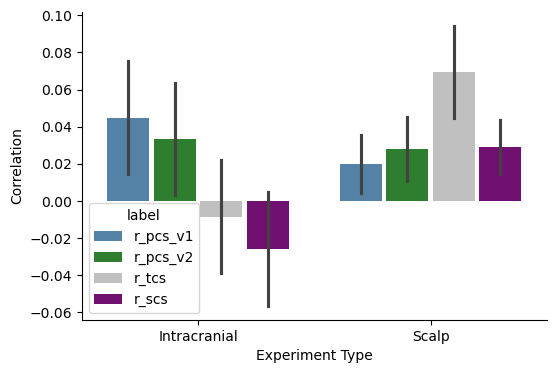

In [24]:
dfm = pd.melt(p_recall_corrs_bsa, id_vars=['subject', 'exp_type', 'experiment'], value_vars=['r_pcs_v1', 'r_pcs_v2', 'r_tcs', 'r_scs'],
              var_name='label', value_name='correlation')

fig, ax = plt.subplots(figsize=(6, 4))

sns.barplot(dfm, x='exp_type', y='correlation', hue='label', palette=['steelblue', 'forestgreen', 'silver', 'purple'], errorbar=('se', 1.96), ax=ax, dodge=True, gap=0.1)

ax.spines[['right', 'top']].set_visible(False)
ax.set(xlabel='Experiment Type', ylabel='Correlation')
ax.set_xticks([0, 1], labels=['Intracranial', 'Scalp'])

plt.show()

In [28]:
stats_final = []
for et, data in p_recall_corrs_bsa.groupby('exp_type'):
    if len(data) > 1:
        res_pcs_v1 = scipy.stats.ttest_1samp(data.r_pcs_v1, popmean=0, nan_policy='omit', alternative='two-sided')
        res_pcs_v2 = scipy.stats.ttest_1samp(data.r_pcs_v2, popmean=0, nan_policy='omit', alternative='two-sided')
        res_tcs = scipy.stats.ttest_1samp(data.r_tcs, popmean=0, nan_policy='omit', alternative='two-sided')
        res_scs = scipy.stats.ttest_1samp(data.r_scs, popmean=0, nan_policy='omit', alternative='two-sided')

        stats_final.append(('pcs_v1', et, res_pcs_v1.statistic, res_pcs_v1.pvalue, res_pcs_v1.df))
        stats_final.append(('pcs_v2', et, res_pcs_v2.statistic, res_pcs_v2.pvalue, res_pcs_v2.df))
        stats_final.append(('tcs', et, res_tcs.statistic, res_tcs.pvalue, res_tcs.df))
        stats_final.append(('scs', et, res_scs.statistic, res_scs.pvalue, res_scs.df))
    
stats_final = pd.DataFrame(stats_final, columns=['label', 'exp_type', 't_stat', 'p_val', 'dof'])

# FDR correction
stats_final['p_val_fdr'] = scipy.stats.false_discovery_control(stats_final.p_val, method='bh')

In [29]:
stats_final

,label,exp_type,t_stat,p_val,dof,p_val_fdr
0,pcs_v1,intracranial,2.883066,4.146613e-03,408,0.008293
1,pcs_v2,intracranial,2.151548,3.201929e-02,408,0.042692
2,tcs,intracranial,-0.542133,5.880228e-01,408,0.588023
3,scs,intracranial,-1.648002,1.001220e-01,408,0.114425
4,pcs_v1,scalp,2.459068,1.528696e-02,126,0.024459
5,pcs_v2,scalp,3.152294,2.024777e-03,126,0.005399
6,tcs,scalp,5.448460,2.564687e-07,126,0.000002
7,scs,scalp,3.905863,1.522571e-04,126,0.000609
